In [2]:
%reload_ext autoreload

%autoreload 2

In [3]:
maxquant_proteingroup_file = "../../test_data/system_tests/MaxQuant_boxcar/proteinGroups.txt"
example_file_maxquant = "../../test_data/system_tests/MaxQuant_boxcar/evidence.txt.maxquant_evidence_benchmark.aq_reformat.tsv"

In [4]:
import pandas as pd
import directlfq.utils as lfq_utils

def load_mq_dataframe(example_mq_file):
    mq_df = pd.read_csv(example_mq_file, sep = "\t")
    mq_df = lfq_utils.index_and_log_transform_input_df(mq_df)
    samples_to_use = [x for x in mq_df.columns if "BoxCar" not in x]
    mq_df = mq_df[samples_to_use]
    return mq_df

def get_list_of_ecoli_proteins(maxquant_proteingroup_file):
    proteins_df  = pd.read_csv(maxquant_proteingroup_file, sep = "\t")
    proteins_df = proteins_df[["id", "Species"]]
    proteins_df = proteins_df[[x == "Escherichia coli" for x in proteins_df["Species"]]]
    ecoli_protein_ids = list(proteins_df['id'].astype('str'))
    return ecoli_protein_ids


mq_df = load_mq_dataframe(example_mq_file=example_file_maxquant)
ecoli_proteins = get_list_of_ecoli_proteins(maxquant_proteingroup_file)

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_16333/1515784.py:12: DtypeWarning: Columns (120,121) have mixed types. Specify dtype option on import or set low_memory=False.
  proteins_df  = pd.read_csv(maxquant_proteingroup_file, sep = "\t")


In [5]:
display(mq_df)
display(mq_df.loc['0'])

Shotgun_02-01_1  Shotgun_02-01_2  \
protein ion                                                           
0       _ADFSGMSQTDLSLSK_2               23.815483              NaN   
        _ELNM(ox)IIMLPDETTDLR_2          23.966224              NaN   
        _ELNMIIMLPDETTDLR_2              26.740082        26.731303   
        _ELNMIIMLPDETTDLR_3                    NaN        24.880823   
        _FCADHPFLFFIQHSK_3               25.008940        24.324161   
...                                            ...              ...   
9;3815  _TLQEVTEMDSVK_2                  27.381708              NaN   
        _TSYAQLLEECPR_2                        NaN              NaN   
        _VTFSGLR_2                             NaN              NaN   
        _VTPGSGALQGQSVSVWELLFYR_3        26.639342        25.930554   
        _YLEGTSCIAGVLVPAK_2              26.472479        25.978452   

                                   Shotgun_02-01_3  Shotgun_12-01_1  \
protein ion                                                           
0       _ADFSGMSQTDLSLSK_2               24.718792              NaN   
        _ELNM(ox)IIMLPDETTDLR_2          24.186087        24.457950   
        _ELNMIIMLPDETTDLR_2              27.076838        27.112075   
        _ELNMIIMLPDETTDLR_3              24.293126        24.472960   
        _FCADHPFLFFIQHSK_3               25.035108        24.509662   
...                                            ...              ...   
9;3815  _TLQEVTEMDSVK_2                  27.291494        27.690991   
        _TSYAQLLEECPR_2                  24.155918        24.388637   
        _VTFSGLR_2                             NaN        24.238851   
        _VTPGSGALQGQSVSVWELLFYR_3        26.192328        26.238687   
        _YLEGTSCIAGVLVPAK_2              26.174285        27.416915   

                                   Shotgun_12-01_2  Shotgun_12-01_3  
protein ion                                                          
0       _ADFSGMSQTDLSLSK_2                     NaN              NaN  
        _ELNM(ox)IIMLPDETTDLR_2          24.711931        24.786362  
        _ELNMIIMLPDETTDLR_2              27.328259        27.048952  
        _ELNMIIMLPDETTDLR_3              24.211560        24.274692  
        _FCADHPFLFFIQHSK_3               25.333506        26.080523  
...                                            ...              ...  
9;3815  _TLQEVTEMDSVK_2                        NaN        27.135259  
        _TSYAQLLEECPR_2                        NaN              NaN  
        _VTFSGLR_2                       23.544511              NaN  
        _VTPGSGALQGQSVSVWELLFYR_3        26.233010        26.376567  
        _YLEGTSCIAGVLVPAK_2              26.622125              NaN  

[78699 rows x 6 columns]

,Shotgun_02-01_1,Shotgun_02-01_2,Shotgun_02-01_3,Shotgun_12-01_1,Shotgun_12-01_2,Shotgun_12-01_3
ion,,,,,,
_ADFSGMSQTDLSLSK_2,23.815483,NaN,24.718792,NaN,NaN,NaN
_ELNM(ox)IIMLPDETTDLR_2,23.966224,NaN,24.186087,24.457950,24.711931,24.786362
_ELNMIIMLPDETTDLR_2,26.740082,26.731303,27.076838,27.112075,27.328259,27.048952
_ELNMIIMLPDETTDLR_3,NaN,24.880823,24.293126,24.472960,24.211560,24.274692
_FCADHPFLFFIQHSK_3,25.008940,24.324161,25.035108,24.509662,25.333506,26.080523
_FCADHPFLFFIQHSK_4,25.828664,25.675999,25.910290,25.483177,25.607300,26.373616
_FYQAEMEELDFISAVEK_2,25.952137,24.772787,24.969258,25.716674,25.317690,NaN
_GNTAAQMAQILSFNK_2,27.505064,26.826992,26.904146,27.285509,NaN,27.751301
_GNTAAQMAQILSFNK_3,23.951182,23.377825,24.187220,24.137274,23.916249,23.918798


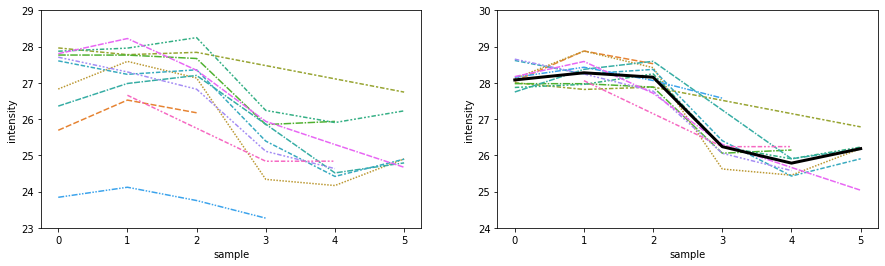

In [25]:
import directlfq.visualizations as lfq_viz

def get_ecoli_proteins_w_specified_number_of_ions(number_ions, mq_df, list_of_ecoli_proteins):
    res = []
    for protein in list_of_ecoli_proteins:
        try:
            prot_df = mq_df.loc[protein]
        except:
            continue
        if (len(prot_df.index)) == number_ions:
            res.append(protein)
    return res



candidate_proteins = get_ecoli_proteins_w_specified_number_of_ions(12, mq_df=mq_df, list_of_ecoli_proteins = ecoli_proteins)
selected_prot  = candidate_proteins[3]

comp_plotter = lfq_viz.IonTraceCompararisonPlotter(mq_df, selected_prot)
fig = comp_plotter.axes[0].get_figure()
comp_plotter.axes[0].set_ylim(23, 29)
comp_plotter.axes[0].set_xlabel("sample")
comp_plotter.axes[0].set_ylabel("intensity")
comp_plotter.axes[1].set_ylim(24, 30)
comp_plotter.axes[1].set_xlabel("sample")
comp_plotter.axes[1].set_ylabel("intensity")

fig.set_figwidth(15)

fig.savefig(f"../../test_data/system_tests/MaxQuant_boxcar/{selected_prot}.pdf")

### Learning Tests


In [6]:
import seaborn as sns

example_df = sns.load_dataset('iris')
example_df1 = example_df.set_index(["species", "petal_width"])
example_df2 = example_df.set_index(["petal_length", "petal_width"])

display(example_df1.loc["setosa"])
display(example_df2.loc[1.4])

,sepal_length,sepal_width,petal_length
petal_width,,,
0.2,5.1,3.5,1.4
0.2,4.9,3.0,1.4
0.2,4.7,3.2,1.3
0.2,4.6,3.1,1.5
0.2,5.0,3.6,1.4
0.4,5.4,3.9,1.7
0.3,4.6,3.4,1.4
0.2,5.0,3.4,1.5
0.2,4.4,2.9,1.4


,sepal_length,sepal_width,species
petal_width,,,
0.2,5.1,3.5,setosa
0.2,4.9,3.0,setosa
0.2,5.0,3.6,setosa
0.3,4.6,3.4,setosa
0.2,4.4,2.9,setosa
0.1,4.8,3.0,setosa
0.3,5.1,3.5,setosa
0.2,5.2,3.4,setosa
0.2,5.5,4.2,setosa
